In [4]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import UnivariateSpline
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import sunpy
import sunpy.map
from sunkit_instruments import suvi
from aiapy.calibrate import register, update_pointing
from scipy import stats
import sunpy.sun.constants as const
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, PercentileInterval

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'

### Projecting multiple observations in the same figure

In [5]:
def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict



def load_aia(start=None, end=None, promote=False, channel=193):
    
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/AIA/{channel}A"
    root_filename = f"aia_lev1_{channel}a_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}"
    data = sorted(glob.glob(f"{data_path}/{root_filename}*.fits"))
    
    # take only 3 hours from start time
    if int(dt_dict['start_hour']) < 10:
        end_hour = f"0{int(dt_dict['start_hour'])}"
    else:
        end_hour = f"{int(dt_dict['start_hour'])+3}"
    
#     start_file_to_find = f"{data_path}/{root_filename}t{dt_dict['start_hour']}_{dt_dict['start_minute']}_04_84z_image_lev1.fits"
#     end_file_to_find = f"{data_path}/{root_filename}t{end_hour}_30_04_84z_image_lev1.fits"
    start_file_to_find = glob.glob(f"{data_path}/{root_filename}t{dt_dict['start_hour']}_{dt_dict['start_minute']}*.fits")[0]
    end_file_to_find   = glob.glob(f"{data_path}/{root_filename}t{end_hour}_{dt_dict['end_minute']}*.fits")[0]
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    map_objects = []
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        print(f'AIA image {i} is loaded')
        if promote:
            # update the metadata of the map to the most recent pointing
            m_updated = update_pointing(m)
            # scale the image to the 0.6"/pix
            # and derotate the image such that the y-axis is aligned with solar North
            m_registered = register(m_updated)
            # exposure time normalization
            m_normalized = m_registered / m_registered.exposure_time
            map_objects.append(m_normalized)
        else:
            map_objects.append(m)
    return map_objects



def load_suvi(start=None, end=None, channel=195):
    """
    * 9.4 nm (FeXVIII)
    * 13.1 nm (FeXXI)
    * 17.1 nm (FeIX/X)
    * 19.5 nm (FeXII)
    * 28.4 nm (FeXV)
    * 30.4 nm (HeII)
    """
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/SUVI/{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}/{channel}A"
    root_filename = f"dr_suvi-l2-ci{channel}_g18_s"
    data = sorted(glob.glob(f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.fits"))
    
    # take only 3 hours from start time
    if int(dt_dict['start_hour']) < 10:
        end_hour = f"0{int(dt_dict['start_hour'])}"
    else:
        end_hour = f"{int(dt_dict['start_hour'])+3}"
    
    start_file_to_find = f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}2800Z_e{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}3200Z_v1-0-2.fits"
    end_file_to_find   = f"{data_path}/{root_filename}{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{end_hour}2800Z_e{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{end_hour}3200Z_v1-0-2.fits"
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = suvi.files_to_map(file, despike_l1b=True)
        min_range = 0
        if channel == 94:
            max_range = 20
        elif channel == 171:
            max_range = 20
        elif channel == 131:
            max_range = 20
        elif channel == 195:
            max_range = 50
        elif channel == 284:
            max_range = 50
        elif channel == 304:
            max_range = 100
        m.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
        map_objects.append(m)
        print(f'SUVI image {i} is done')
    return map_objects



def load_lasco(start=None, end=None, detector='C2'):
    
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/LASCO_{detector}"
    data = sorted(glob.glob(f"{data_path}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    start_file_to_find = f"{data_path}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find   = f"{data_path}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        if detector == 'C2':
            m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        elif detector == 'C3':
            m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=200)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())

In [6]:
start = '2024-05-14T16:30:00'
end   = '2024-05-14T23:59:59'

datetime_dict = split_datetime(start=start, end=end)

datetime_dict

{'start_year': '2024',
 'start_month': '05',
 'start_day': '14',
 'start_hour': '16',
 'start_minute': '30',
 'start_second': '00',
 'end_year': '2024',
 'end_month': '05',
 'end_day': '14',
 'end_hour': '23',
 'end_minute': '59',
 'end_second': '59'}

In [5]:
aia_channel = 193
suvi_channel = 195

aia_map_objects = load_aia(start='2024-05-14T16:30:00', end='2024-05-14T19:31:00', channel=aia_channel)
suvi_map_objects = load_suvi(start='2024-05-14T16:30:00', end='2024-05-14T19:31:00', channel=suvi_channel)

AIA image 0 is loaded
AIA image 1 is loaded
AIA image 2 is loaded
AIA image 3 is loaded
AIA image 4 is loaded
AIA image 5 is loaded
AIA image 6 is loaded
AIA image 7 is loaded
AIA image 8 is loaded
AIA image 9 is loaded
AIA image 10 is loaded
AIA image 11 is loaded
AIA image 12 is loaded
AIA image 13 is loaded
AIA image 14 is loaded
AIA image 15 is loaded
AIA image 16 is loaded
AIA image 17 is loaded
AIA image 18 is loaded
AIA image 19 is loaded
AIA image 20 is loaded
AIA image 21 is loaded
AIA image 22 is loaded
AIA image 23 is loaded
AIA image 24 is loaded
AIA image 25 is loaded
AIA image 26 is loaded
AIA image 27 is loaded
AIA image 28 is loaded
AIA image 29 is loaded
AIA image 30 is loaded
AIA image 31 is loaded
AIA image 32 is loaded
AIA image 33 is loaded
AIA image 34 is loaded
AIA image 35 is loaded
AIA image 36 is loaded
AIA image 37 is loaded
AIA image 38 is loaded
AIA image 39 is loaded
AIA image 40 is loaded
AIA image 41 is loaded
AIA image 42 is loaded
AIA image 43 is loade

LASCO C2 image 420 is done
LASCO C2 image 421 is done
LASCO C2 image 422 is done
LASCO C2 image 423 is done
LASCO C2 image 424 is done
LASCO C2 image 425 is done
LASCO C2 image 426 is done
LASCO C2 image 427 is done
LASCO C2 image 428 is done
LASCO C2 image 429 is done
LASCO C2 image 430 is done
LASCO C2 image 431 is done
LASCO C2 image 432 is done
LASCO C2 image 433 is done
LASCO C2 image 434 is done
LASCO C2 image 435 is done
LASCO C2 image 436 is done
LASCO C2 image 437 is done
LASCO C2 image 438 is done
LASCO C2 image 439 is done
LASCO C2 image 440 is done
LASCO C2 image 441 is done
LASCO C2 image 442 is done
LASCO C2 image 443 is done
LASCO C2 image 444 is done
LASCO C2 image 445 is done
LASCO C2 image 446 is done
LASCO C2 image 447 is done
LASCO C2 image 448 is done
LASCO C3 image 0 is done
LASCO C3 image 1 is done
LASCO C3 image 2 is done
LASCO C3 image 3 is done
LASCO C3 image 4 is done
LASCO C3 image 5 is done
LASCO C3 image 6 is done
LASCO C3 image 7 is done
LASCO C3 image 8 

LASCO C3 image 280 is done
LASCO C3 image 281 is done
LASCO C3 image 282 is done
LASCO C3 image 283 is done
LASCO C3 image 284 is done
LASCO C3 image 285 is done
LASCO C3 image 286 is done
LASCO C3 image 287 is done
LASCO C3 image 288 is done
LASCO C3 image 289 is done
LASCO C3 image 290 is done
LASCO C3 image 291 is done
LASCO C3 image 292 is done
LASCO C3 image 293 is done
LASCO C3 image 294 is done
LASCO C3 image 295 is done
LASCO C3 image 296 is done
LASCO C3 image 297 is done
LASCO C3 image 298 is done
LASCO C3 image 299 is done
LASCO C3 image 300 is done
LASCO C3 image 301 is done
LASCO C3 image 302 is done
LASCO C3 image 303 is done
LASCO C3 image 304 is done
LASCO C3 image 305 is done
LASCO C3 image 306 is done
LASCO C3 image 307 is done
LASCO C3 image 308 is done
LASCO C3 image 309 is done
LASCO C3 image 310 is done
LASCO C3 image 311 is done
LASCO C3 image 312 is done
LASCO C3 image 313 is done
LASCO C3 image 314 is done
LASCO C3 image 315 is done
LASCO C3 image 316 is done
L

In [7]:
c2_map_objects = load_lasco(start='2024-05-14T16:30:00', end='2024-05-14T23:59:59', detector='C2')
c3_map_objects = load_lasco(start='2024-05-14T16:30:00', end='2024-05-14T23:59:59', detector='C3')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

In [6]:
print(len(aia_map_objects), len(suvi_map_objects), len(c2_map_objects), len(c3_map_objects))

180 45 449 449


In [7]:
clean_aia_maps = remove_redundant_maps(aia_map_objects)
clean_suvi_maps = remove_redundant_maps(suvi_map_objects)
clean_c2_maps = remove_redundant_maps(c2_map_objects)
clean_c3_maps = remove_redundant_maps(c3_map_objects)

In [8]:
print(len(clean_aia_maps), len(clean_suvi_maps), len(clean_c2_maps), len(clean_c3_maps))

180 45 35 35


In [9]:
aia = clean_aia_maps[0]
suv = clean_suvi_maps[0]
c2 = clean_c2_maps[0]
c3 = clean_c3_maps[0]

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


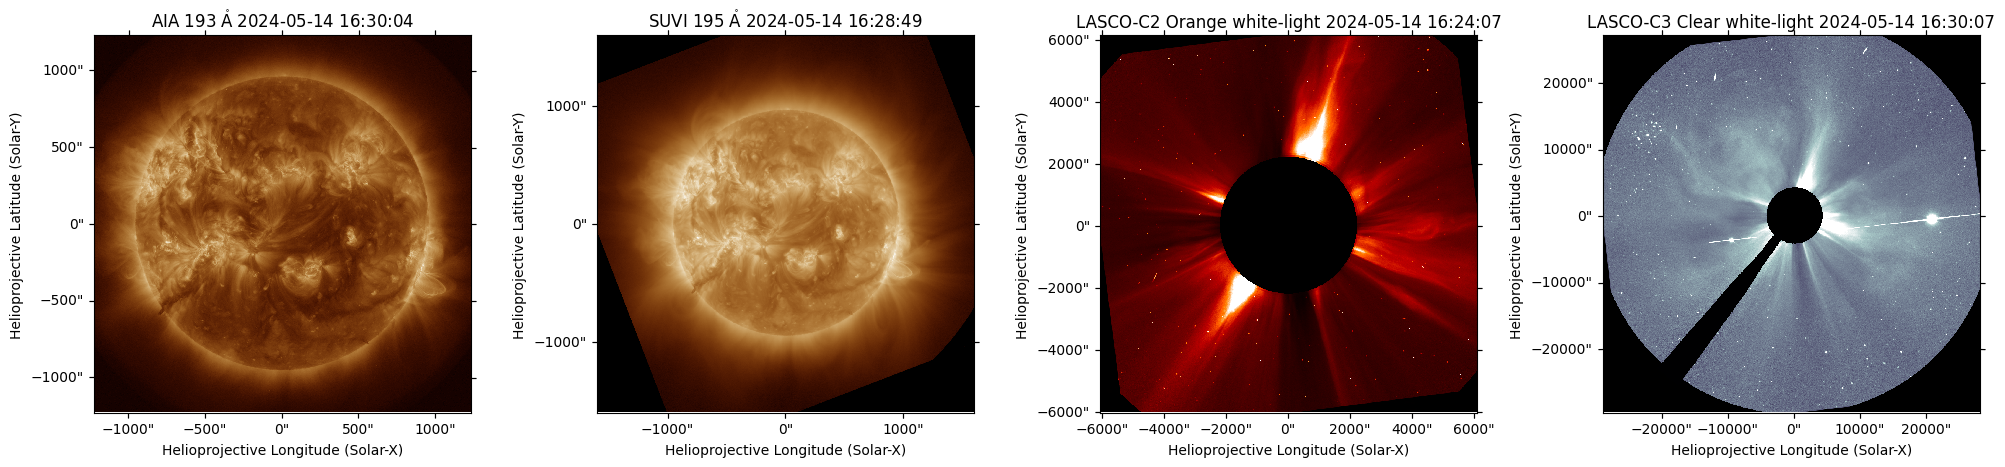

In [10]:
fig = plt.figure(figsize=[20,7])

ax = fig.add_subplot(141, projection=aia)
aia.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(142, projection=suv)
suv.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(143, projection=c2)
c2.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(144, projection=c3)
c3.plot(axes=ax)
ax.grid(False)

fig.tight_layout()
plt.show()

### Projecting multiple instruments FOVs

In [ ]:
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111, projection=c2)
# c2.plot(axes=ax)
# aia.plot(axes=ax, autoalign=True)
# ax.grid(False)
# ax.set_title(' ')

# # Define the title text
# title_text = f"AIA {aia_channel}$\AA$: {aia.meta['date-obs'].split('T')[1]}\nLASCO C2: {c2.meta['time_obs']}"

# # Add the title text to the bottom left of the plot
# ax.text(0.01, 0.01, title_text, transform=ax.transAxes, color='white', fontsize=12,
#         verticalalignment='bottom', horizontalalignment='left')
# #         bbox=dict(facecolor='white', alpha=0.4))
# fig.tight_layout()
# plt.show()

In [ ]:
# projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
#                            obstime=c2.observer_coordinate.obstime,
#                            frame='helioprojective',
#                            observer=c2.observer_coordinate,
#                            rsun=aia.coordinate_frame.rsun)

# projected_header = sunpy.map.make_fitswcs_header(aia.data.shape,
#                                                  projected_coord,
#                                                  scale=u.Quantity(aia.scale),
#                                                  instrument=aia.instrument,
#                                                  wavelength=aia.wavelength)

# # We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# # otherwise it will only be the on disk pixels that are reprojected.
# with Helioprojective.assume_spherical_screen(aia.observer_coordinate):
#     aia_reprojected = aia.reproject_to(projected_header)

In [ ]:
# projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
#                            obstime=c3.observer_coordinate.obstime,
#                            frame='helioprojective',
#                            observer=c3.observer_coordinate,
#                            rsun=aia.coordinate_frame.rsun)

# projected_header = sunpy.map.make_fitswcs_header(aia.data.shape,
#                                                  projected_coord,
#                                                  scale=u.Quantity(aia.scale),
#                                                  instrument=aia.instrument,
#                                                  wavelength=aia.wavelength)

# # We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# # otherwise it will only be the on disk pixels that are reprojected.
# with Helioprojective.assume_spherical_screen(aia.observer_coordinate):
#     aia_reprojected = aia.reproject_to(projected_header)

In [ ]:
# projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
#                            obstime=c3.observer_coordinate.obstime,
#                            frame='helioprojective',
#                            observer=c3.observer_coordinate,
#                            rsun=c2.coordinate_frame.rsun)

# projected_header = sunpy.map.make_fitswcs_header(c2.data.shape,
#                                                  projected_coord,
#                                                  scale=u.Quantity(c2.scale),
#                                                  instrument=c2.instrument,
#                                                  wavelength=c2.wavelength)

# # We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# # otherwise it will only be the on disk pixels that are reprojected.
# with Helioprojective.assume_spherical_screen(c2.observer_coordinate):
#     c2_reprojected = c2.reproject_to(projected_header)

In [12]:
print('aia:\t', aia.meta['date-obs'].split('T')[1])
print('suvi:\t', suv.meta['date-obs'].split('T')[1])
print('lasco c2:\t', c2.meta['time_obs'])
print('lasco c3:\t', c3.meta['time_obs'])

aia:	 16:30:04.84
suvi:	 16:28:49.407
lasco c2:	 16:24:07.626
lasco c3:	 16:30:07.422


In [ ]:
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111, projection=lasco_c3_map)
# lasco_c3_map.plot(axes=ax)
# lasco_c2_reprojected.plot(axes=ax, autoalign=True)
# suvi_reprojected.plot(axes=ax, autoalign=True)
# ax.grid(False)
# ax.set_title(' ')

# # Define the title text
# title_text = f"SUVI: {suvi_map.meta['date-obs'].split('T')[1]}\nLASCO C2: {lasco_c2_map.meta['time_obs']}\nLASCO C3: {lasco_c3_map.meta['time_obs']}"

# # Add the title text to the bottom left of the plot
# ax.text(0.01, 0.01, title_text, transform=ax.transAxes, color='white', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
# #         bbox=dict(facecolor='white', alpha=0.4))
# fig.tight_layout()
# plt.show()

# Preparing running-ratio images

In [8]:
# make running-ratio images
def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
    Inputs: list of EUV sunpy maps.
    Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'seismic'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax



def round_obstime(time=None):
    """
    Round the observation time to put it in the image title.
    Input : str, time (HH:MM:SS.sss)
    Output: str, datetime (YYYY-mm-DD HH:MM:SS)
    """
    from datetime import datetime, timedelta

    original_time_str = time

    # Convert the original time string to a datetime object
    original_time = datetime.strptime(original_time_str, '%H:%M:%S.%f')

    # Round the time to the nearest second
    rounded_time = original_time + timedelta(seconds=round(original_time.microsecond / 1e6))

    # Format the rounded time as 'HH:MM:SS'
    rounded_time_str = rounded_time.strftime('%H:%M:%S')
    
    return rounded_time_str

## AIA

In [9]:
aia_131_map_objects = load_aia(start='2024-05-14T16:30:00', end='2024-05-14T19:30:00', channel=131)
aia_171_map_objects = load_aia(start='2024-05-14T16:30:00', end='2024-05-14T19:30:00', channel=171)
aia_193_map_objects = load_aia(start='2024-05-14T16:30:00', end='2024-05-14T19:30:00', channel=193)

AIA image 0 is loaded
AIA image 1 is loaded
AIA image 2 is loaded
AIA image 3 is loaded
AIA image 4 is loaded
AIA image 5 is loaded
AIA image 6 is loaded
AIA image 7 is loaded
AIA image 8 is loaded
AIA image 9 is loaded
AIA image 10 is loaded
AIA image 11 is loaded
AIA image 12 is loaded
AIA image 13 is loaded
AIA image 14 is loaded
AIA image 15 is loaded
AIA image 16 is loaded
AIA image 17 is loaded
AIA image 18 is loaded
AIA image 19 is loaded
AIA image 20 is loaded
AIA image 21 is loaded
AIA image 22 is loaded
AIA image 23 is loaded
AIA image 24 is loaded
AIA image 25 is loaded
AIA image 26 is loaded
AIA image 27 is loaded
AIA image 28 is loaded
AIA image 29 is loaded
AIA image 30 is loaded
AIA image 31 is loaded
AIA image 32 is loaded
AIA image 33 is loaded
AIA image 34 is loaded
AIA image 35 is loaded
AIA image 36 is loaded
AIA image 37 is loaded
AIA image 38 is loaded
AIA image 39 is loaded
AIA image 40 is loaded
AIA image 41 is loaded
AIA image 42 is loaded
AIA image 43 is loade

In [10]:
print(len(aia_131_map_objects), len(aia_171_map_objects), len(aia_193_map_objects))

180 180 180


In [11]:
# channel = 131
# dt_dict = split_datetime(start=start, end=end)
# data_path = f"{data_dir}/AIA/{channel}A"
# root_filename = f"aia_lev1_{channel}a_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}"
# data = sorted(glob.glob(f"{data_path}/{root_filename}*.fits"))
# print(len(data))

In [12]:
# # validation
# for m in aia_131_map_objects:
#     print(f"{m.meta['date-obs']} {m.meta['wavelnth']}A")

In [ ]:
# make run-ratio maps
m_seq_runratio_131A = apply_runratio(aia_131_map_objects)
m_seq_runratio_171A = apply_runratio(aia_171_map_objects)
m_seq_runratio_193A = apply_runratio(aia_193_map_objects)

print(len(m_seq_runratio_131A), len(m_seq_runratio_171A), len(m_seq_runratio_193A))




aia_rgb = []
for idx, _ in enumerate(m_seq_runratio_131A):
    
    rgb_image = np.stack([m_seq_runratio_131A[idx].data,
                          m_seq_runratio_171A[idx].data,
                          m_seq_runratio_193A[idx].data],
                         axis=-1)
    
    # Enhance contrast for each channel
    rgb_image_enhanced = np.zeros_like(rgb_image)
    for i in range(3):  # Process each channel independently
        vmin, vmax = calculate_percentiles(rgb_image[..., i])
        rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
    
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image_enhanced, axis=2)
    m = sunpy.map.Map(array_2d, m_seq_runratio_131A[idx].meta)
    aia_rgb.append(m)
    print(f'Image {idx} is done')

print(len(aia_rgb))

179 179 179
Image 0 is done
Image 1 is done
Image 2 is done
Image 3 is done
Image 4 is done
Image 5 is done
Image 6 is done
Image 7 is done
Image 8 is done
Image 9 is done
Image 10 is done
Image 11 is done
Image 12 is done
Image 13 is done
Image 14 is done
Image 15 is done
Image 16 is done
Image 17 is done
Image 18 is done
Image 19 is done
Image 20 is done
Image 21 is done
Image 22 is done
Image 23 is done
Image 24 is done
Image 25 is done
Image 26 is done
Image 27 is done
Image 28 is done
Image 29 is done
Image 30 is done
Image 31 is done
Image 32 is done
Image 33 is done
Image 34 is done
Image 35 is done
Image 36 is done
Image 37 is done
Image 38 is done
Image 39 is done
Image 40 is done
Image 41 is done
Image 42 is done
Image 43 is done
Image 44 is done
Image 45 is done
Image 46 is done
Image 47 is done
Image 48 is done
Image 49 is done
Image 50 is done


In [ ]:
1

In [ ]:
for m i aia_rgb:
    m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'seismic'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3, stretch=SqrtStretch())

## SUVI

In [16]:
suvi_171_map_objects = load_suvi(start='2024-05-14T16:30:00', end='2024-05-14T19:31:00', channel=171)
suvi_195_map_objects = load_suvi(start='2024-05-14T16:30:00', end='2024-05-14T19:31:00', channel=195)
suvi_284_map_objects = load_suvi(start='2024-05-14T16:30:00', end='2024-05-14T19:31:00', channel=284)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done
SUVI image 22 is done
SUVI image 23 is done
SUVI image 24 is done
SUVI image 25 is done
SUVI image 26 is done
SUVI image 27 is done
SUVI image 28 is done
SUVI image 29 is done
SUVI image 30 is done
SUVI image 31 is done
SUVI image 32 is done
SUVI image 33 is done
SUVI image 34 is done
SUVI image 35 is done
SUVI image 36 is done
SUVI image 37 is done
SUVI image 38 is done
SUVI image 39 is done
SUVI image 40 is done
SUVI image 41 is done
SUVI image 42 is done
SUVI image 43 is done
SUVI image 44 is done
SUVI image 0 is done

ValueError: '/home/mnedal/data/SUVI/20240514/211A/dr_suvi-l2-ci211_g18_s20240514T162800Z_e20240514T163200Z_v1-0-2.fits' is not in list

In [19]:
print(len(suvi_171_map_objects), len(suvi_195_map_objects), len(suvi_284_map_objects))

45 45 45


In [23]:
# make run-ratio maps
m_seq_runratio_171A = apply_runratio(suvi_171_map_objects)
m_seq_runratio_195A = apply_runratio(suvi_195_map_objects)
m_seq_runratio_284A = apply_runratio(suvi_284_map_objects)

print(len(m_seq_runratio_171A), len(m_seq_runratio_195A), len(m_seq_runratio_284A))

suvi_rgb = []
for idx, _ in enumerate(m_seq_runratio_171A):
    
    rgb_image = np.stack([m_seq_runratio_171A[idx].data,
                          m_seq_runratio_195A[idx].data,
                          m_seq_runratio_284A[idx].data],
                         axis=-1)
    
    # Enhance contrast for each channel
    rgb_image_enhanced = np.zeros_like(rgb_image)
    for i in range(3):  # Process each channel independently
        vmin, vmax = calculate_percentiles(rgb_image[..., i])
        rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
    
    # Convert the 3D array to a 2D array by averaging the channels
    array_2d = np.mean(rgb_image_enhanced, axis=2)
    m = sunpy.map.Map(array_2d, m_seq_runratio_171A[idx].meta)
    suvi_rgb.append(m)

print(len(suvi_rgb))

44 44 44
44


In [24]:
for m in suvi_rgb:
    m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'seismic'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3, stretch=SqrtStretch())

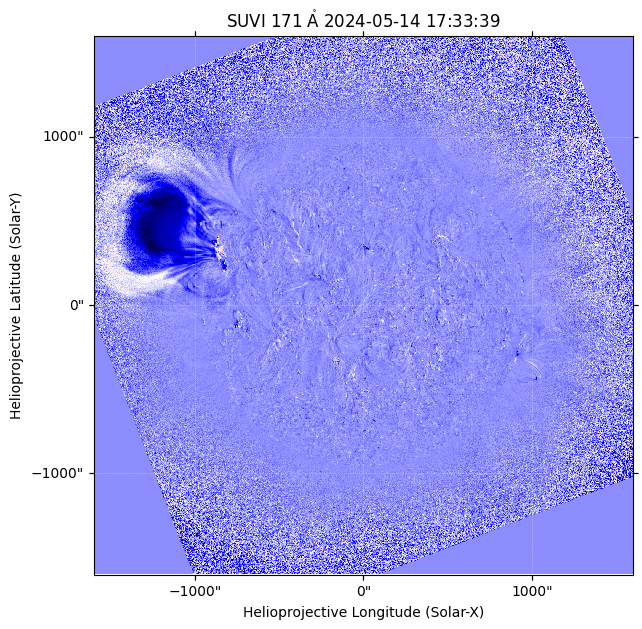

In [29]:
m = suvi_rgb[15]

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
plt.show()

## LASCO C2

In [30]:
m_seq_runratio_c2 = apply_runratio(clean_c2_maps)

for m in m_seq_runratio_c2:
    m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'seismic'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [31]:
print(len(m_seq_runratio_c2))

34


In [1]:
m = m_seq_runratio_c2[8]

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
plt.show()

NameError: name 'm_seq_runratio_c2' is not defined

## LASCO C3

In [32]:
m_seq_runratio_c3 = apply_runratio(clean_c3_maps)

for m in m_seq_runratio_c3:
    m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'seismic'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [33]:
print(len(m_seq_runratio_c3))

34


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


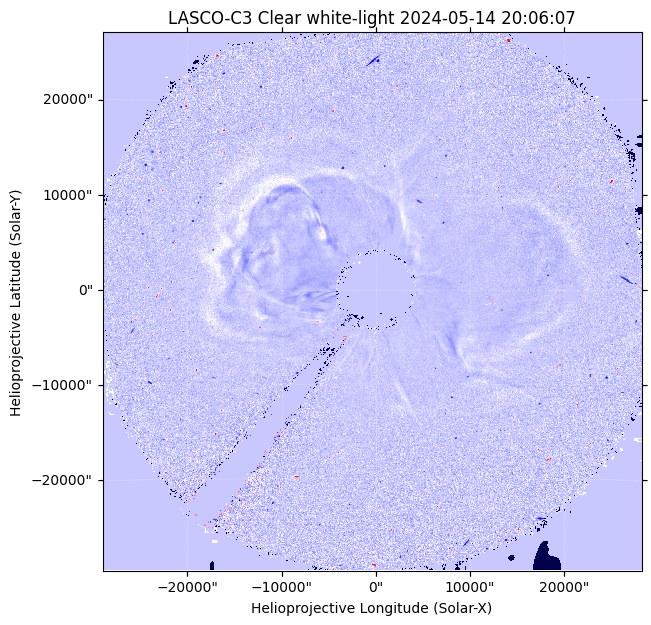

In [51]:
m = m_seq_runratio_c3[17]

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
plt.show()

### Projecting run-ratio AIA or SUVI RGB on run-ratio LASCO C2 and LASCO C3

In [56]:
aia_map = m_seq_runratio_aia193[...]
suvi_map = suvi_rgb[22]
lasco_c2_map = m_seq_runratio_c2[7]
lasco_c3_map = m_seq_runratio_c3[7]


projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_c3_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_c3_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)

projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)

# We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_map_reprojected = aia_map.reproject_to(projected_header)


projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_c3_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_c3_map.observer_coordinate,
                           rsun=suvi_map.coordinate_frame.rsun)

projected_header = sunpy.map.make_fitswcs_header(suvi_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(suvi_map.scale),
                                                 instrument=suvi_map.instrument,
                                                 wavelength=suvi_map.wavelength)

# We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(suvi_map.observer_coordinate):
    suvi_reprojected = suvi_map.reproject_to(projected_header)


projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_c3_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_c3_map.observer_coordinate,
                           rsun=lasco_c2_map.coordinate_frame.rsun)

projected_header = sunpy.map.make_fitswcs_header(lasco_c2_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(lasco_c2_map.scale),
                                                 instrument=lasco_c2_map.instrument,
                                                 wavelength=lasco_c2_map.wavelength)

# We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(lasco_c2_map.observer_coordinate):
    lasco_c2_reprojected = lasco_c2_map.reproject_to(projected_header)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


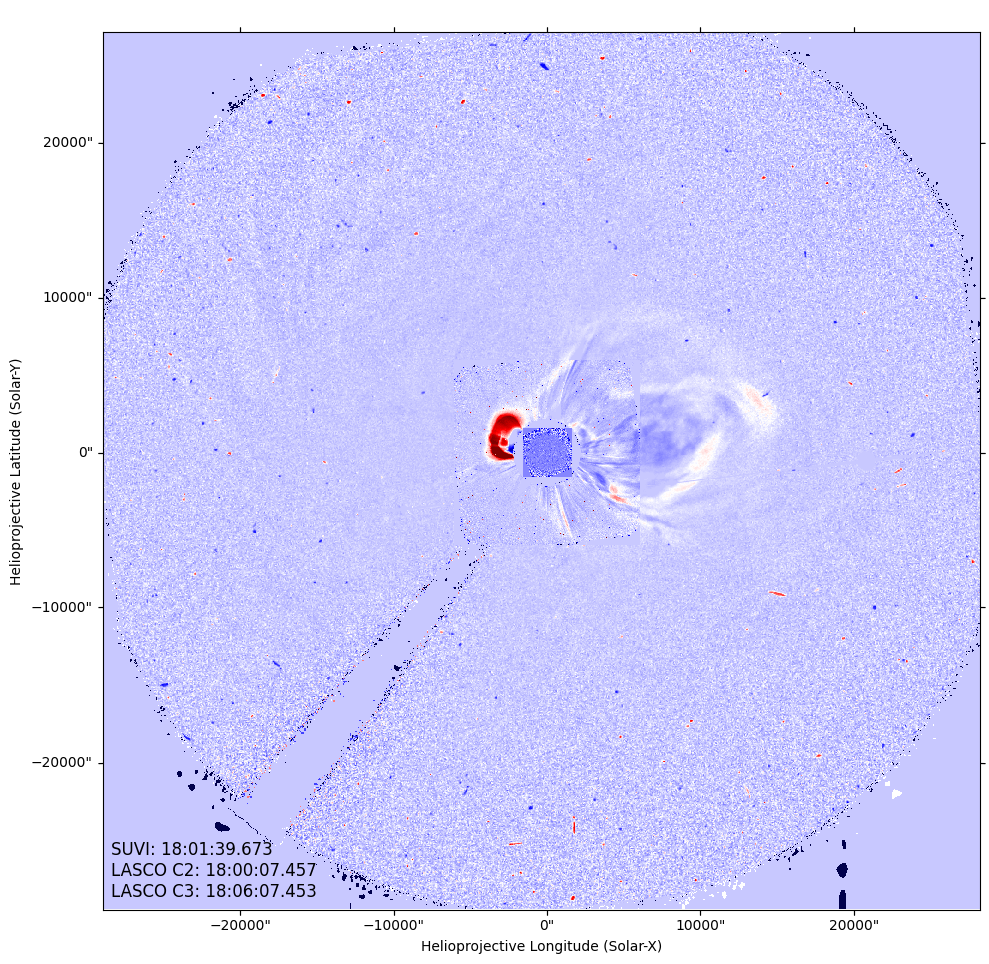

In [57]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=lasco_c3_map)
lasco_c3_map.plot(axes=ax)
lasco_c2_reprojected.plot(axes=ax, autoalign=True)
suvi_reprojected.plot(axes=ax, autoalign=True)
ax.grid(False)
ax.set_title(' ')

# Define the title text
title_text = f"SUVI: {suvi_map.meta['date-obs'].split('T')[1]}\nLASCO C2: {lasco_c2_map.meta['time_obs']}\nLASCO C3: {lasco_c3_map.meta['time_obs']}"

# Add the title text to the bottom left of the plot
ax.text(0.01, 0.01, title_text, transform=ax.transAxes, color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
fig.tight_layout()
plt.show()